In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,) , (0.5,))#均值和方差设为0.5就是将取值范围从0~1放到了-1~1
    ###注！！！！！Normalize不能直接(0.5,0.5) 要改成上面那样，推测是torch版本导致的
])

In [5]:
train_ds=torchvision.datasets.MNIST('data',train=True,transform=transform,download=True)
dataloader=torch.utils.data.DataLoader(train_ds,batch_size=64,shuffle=True)

In [6]:
#z=torch.randn(batchsize,100,1,1) #可以这么定义噪声，这样就是一个channel为100的1*1的噪声，就不用再s使用linear层和reshape了（在pytorch中第一个维度是c）
batchsize=64
z=torch.randn(batchsize,100)#这里为了更直观一点就加linear层了

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.linear1=nn.Linear(100,256*7*7) #为什么选7*&因为两次反卷积之后就是minist的28*28了
        self.bn1=nn.BatchNorm1d(256*7*7) #因为此时是一维的所以用1d
        self.deconv1=nn.ConvTranspose2d(256,128, #我们要使通道数越来越小直到1（灰度图像）
                                kernel_size=(3,3),#卷积核一般都是3*3，也可以定义成其他的
                                stride=1,#7->28只需要反卷积两次，但是为了提高反卷积层的生成能力，可以把跨度设为1，不进行缩放，可以多加几层反卷积
                                padding=1)#要是不进行缩放的话卷积核为3就得进行1的填充
                                    #(128,7,7)
        self.bn2=nn.BatchNorm2d(128)
        self.deconv2=nn.ConvTranspose2d(128,64,kernel_size=(4,4),stride=2,padding=1) #为了使生成图片大小正好是14*14的，所以调整了一下卷积核
                                    #(64，14,14)
        self.bn3=nn.BatchNorm2d(64)
        self.deconv3=nn.ConvTranspose2d(64,1,kernel_size=(4,4),stride=2,padding=1) 
                                    #(1,28,28)

    def forward(self,x):
        x=F.relu(self.linear1(x))
        x=self.bn1(x)
        x=x.view(-1,256,7,7)
        x=F.relu(self.deconv1(x))
        x=self.bn2(x)
        x=F.relu(self.deconv2(x))
        x=self.bn3(x)
        x=torch.tanh(self.deconv3(x))
        return x




In [8]:
Generator()

Generator(
  (linear1): Linear(in_features=100, out_features=12544, bias=True)
  (bn1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [78]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1=nn.Conv2d(1,64,3,stride=2) #判别器的输入不能有BN层
        self.conv2=nn.Conv2d(64,128,3,stride=2)
        self.bn=nn.BatchNorm2d(128)
        self.Fc=nn.Linear(128*6*6,1)
    def forward(self,x):
        x=F.dropout2d(F.leaky_relu(self.conv1(x)))#注意在判别器中使用leakyrelu进行激活  使用dropout层来使得判别器不会过强
        x=F.dropout2d(F.leaky_relu(self.conv2(x)))#现在的输出结果为(batch,128,6,6)
        x=self.bn(x)
        x=x.view(-1,128*6*6) #除了batch外将图片的数据展平
        x=torch.sigmoid(self.Fc(x))
        return x



In [73]:
lay=nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=2)

In [74]:
inp=torch.randn(8,128,7,7)

In [75]:
out=lay(inp)

In [76]:
out.size()

torch.Size([8, 64, 12, 12])

In [80]:
device='cuda' if torch.cuda.is_available() else 'cpu'
gen=Generator().to(device)
dis=Discriminator().to(device)
loss_fn=nn.BCELoss()
g_optim=torch.optim.Adam(gen.parameters(),lr=1e-4) #可以使生成器的学习速率大于判别器从而避免判别器过强
d_optim=torch.optim.Adam(dis.parameters(),lr=1e-5)


In [88]:
def gen_and_save_img(model,epoch,test_input):
    pre=np.squeeze(model(test_input).cpu().numpy())
    fig=plt.figure(figsize=(4,4))
    for i in range(pre.shape[0]): #这里得用中括号
        plt.subplot(4,4,i+1)
        plt.imshow((pre[i]+1)/2,cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [82]:
test_input=torch.randn(16,100,device=device)

In [83]:
D_loss=[]
G_loss=[]#建立两个空列表来存损失

Epoch: 0


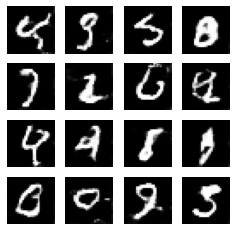

Epoch: 1


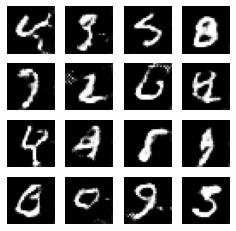

Epoch: 2


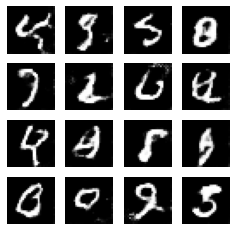

Epoch: 3


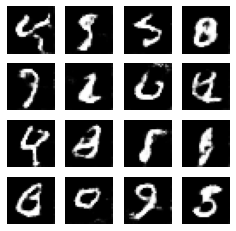

Epoch: 4


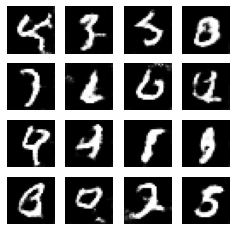

Epoch: 5


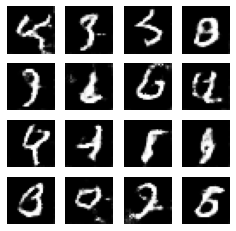

Epoch: 6


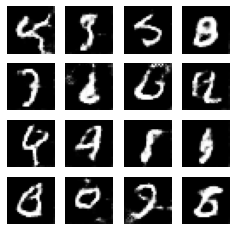

Epoch: 7


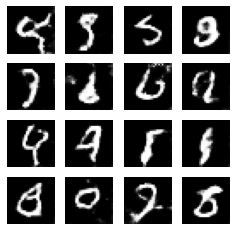

Epoch: 8


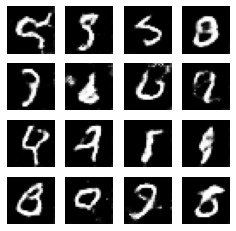

Epoch: 9


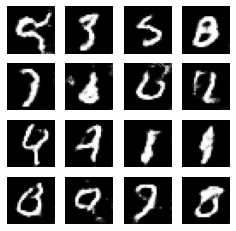

Epoch: 10


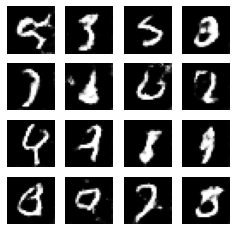

Epoch: 11


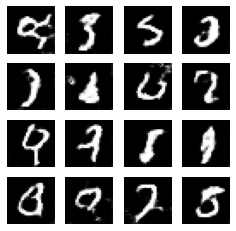

Epoch: 12


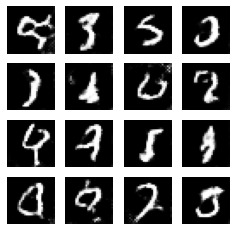

Epoch: 13


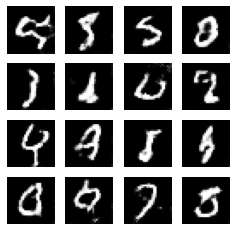

Epoch: 14


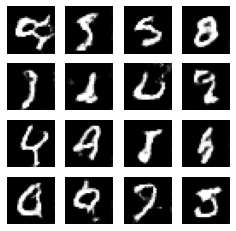

Epoch: 15


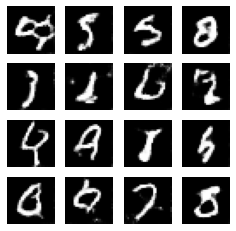

Epoch: 16


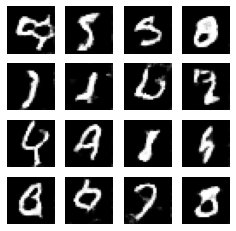

Epoch: 17


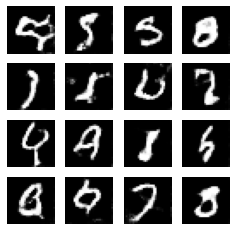

Epoch: 18


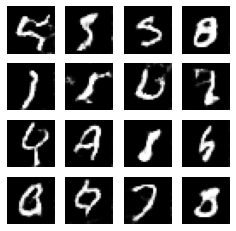

Epoch: 19


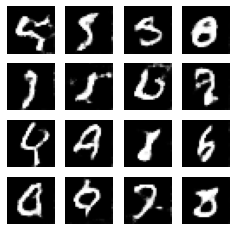

Epoch: 20


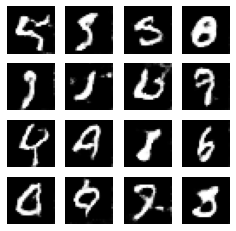

Epoch: 21


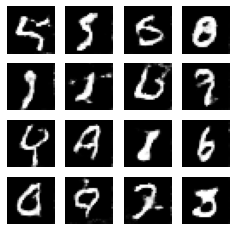

Epoch: 22


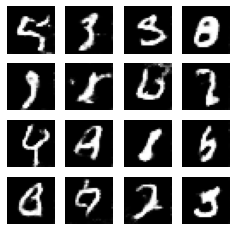

Epoch: 23


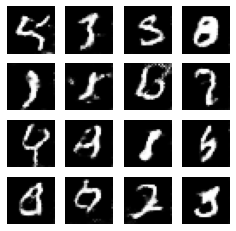

Epoch: 24


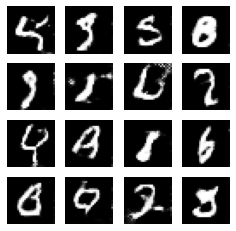

Epoch: 25


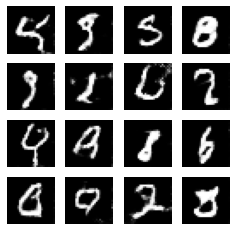

Epoch: 26


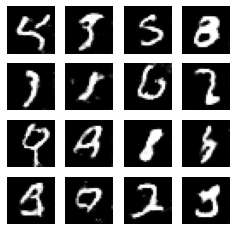

Epoch: 27


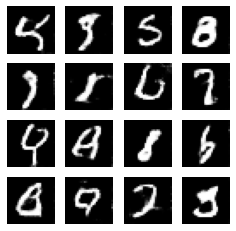

Epoch: 28


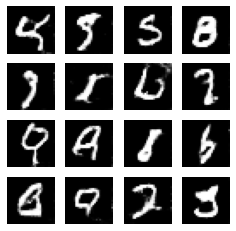

Epoch: 29


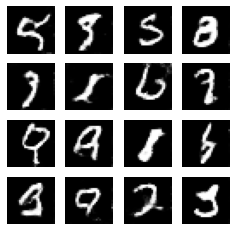

Epoch: 30


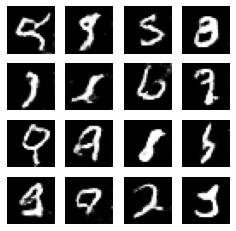

Epoch: 31


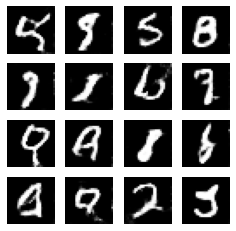

Epoch: 32


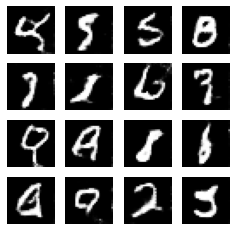

Epoch: 33


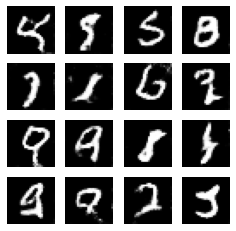

Epoch: 34


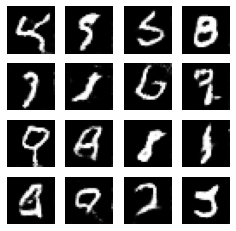

Epoch: 35


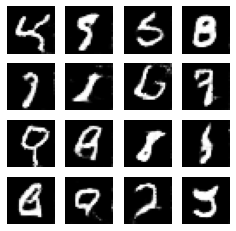

Epoch: 36


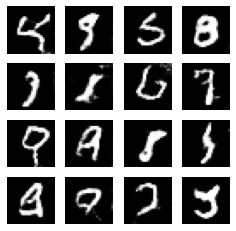

Epoch: 37


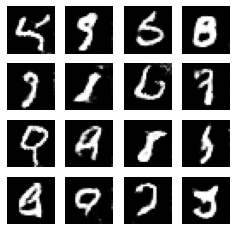

Epoch: 38


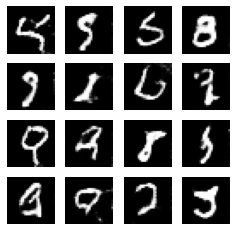

Epoch: 39


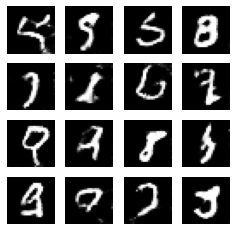

In [91]:
for epoch in range(40):
    d_epoch_loss=0
    g_epoch_loss=0
    count=len(dataloader) #a=len(dataloader)会返回batch数，b=len(dataset)会返回样本总数 （b=a*batch_size）

    for step, (img, _) in enumerate(dataloader):#需要epoch号和图像，不需要标签
        img=img.to(device)#先把数据放到GPU上
        size=img.size(0)#相当于batch_size，生成这么多个随机数正好和一个批次的图像向对应
        random_noise=torch.randn(size,100,device=device)
        
        #判别器的损失
        d_optim.zero_grad() #对于判别器而言损失有两个部分,真实图像的损失和生成图像的损失
        real_output=dis(img) #判别器输入真实的图片，得到对真实图片的预测结果，我们希望real_output为1
        d_real_loss=loss_fn(real_output,#因为我们对真实图片希望输出结果是1，所以计算它和全1的数组
                    torch.ones_like(real_output)) #torch.ones_like(a)是输出a的样式那么多个1，如a是5*5的数组，这个就输出5*5的1
        d_real_loss.backward()

        gen_img=gen(random_noise)
        fake_output=dis(gen_img.detach())#判别器输入生成的图片，因为这里也是对判别器的训练，所以使用detach将梯度截取不影响gen的训练，使梯度不再传送到gen的模型中了
        d_fake_loss=loss_fn(fake_output,torch.zeros_like(fake_output))
        d_fake_loss.backward()

        d_loss=d_real_loss+d_fake_loss
        d_optim.step()

        #生成器的损失
        g_optim.zero_grad()
        fake_output=dis(gen_img) #此时就不需要截断了，因为此时就需要梯度来训练优化GAN
        g_loss=loss_fn(fake_output,torch.ones_like(fake_output)) #对于生成器我们希望判别器判断的的结果为1,就是希望生成的图片被判断为真
        g_loss.backward()
        g_optim.step()

        with torch.no_grad():#将每个epoch中批次的的所有loss求和
            d_epoch_loss+=d_loss.item() #得到的loss是标量tensor，使用item获取它的值
            g_epoch_loss+=g_loss.item()
    with torch.no_grad():  #求每个epoch的平均loss再放到列表中
        d_epoch_loss/=count
        g_epoch_loss/=count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print('Epoch:',epoch)
        gen_and_save_img(gen,epoch,test_input)#使用一个固定的噪声而不是每个epoch都变的噪声从而更明显的看出来优化变化的结果

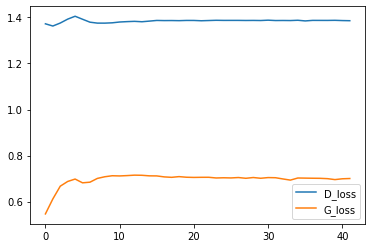

In [90]:
#因为之前.item()了，所以可以直接用loss
plt.plot(D_loss,label='D_loss') 
plt.plot(G_loss,label='G_loss')
plt.legend()

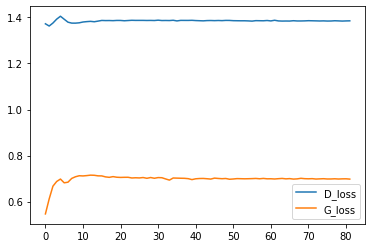

In [92]:
plt.plot(D_loss,label='D_loss') 
plt.plot(G_loss,label='G_loss')
plt.legend()